In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
B1 = 1.2
B0 = 0.6

In [3]:
x = np.linspace(0, 10, 11)
y = B1 * x + B0

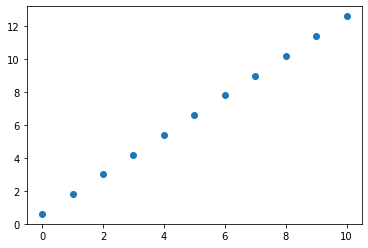

In [4]:
plt.plot(x, y, 'o')

0.6506506506506504
1.1911911911911908


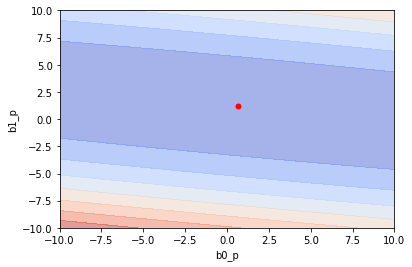

In [5]:
granularity = 1000
b0_p = np.linspace(-10, 10, granularity)
b1_p = np.linspace(-10, 10, granularity)
B0_P, B1_P = np.meshgrid(b0_p, b1_p)
B = np.vstack((B1_P.flatten(), B0_P.flatten()))
X = np.vstack((x, np.ones((1, x.shape[0])))).T
Y_p = np.dot(X, B)
Y = np.repeat(y, granularity * granularity).reshape(y.shape[0], granularity * granularity)
L = np.sum(np.power(Y - Y_p, 2), axis = 0).reshape(granularity, granularity)

fig, ax = plt.subplots()

ax.contourf(B0_P, B1_P, L, cmap=cm.coolwarm, alpha = 0.5)

ax.set_xlabel('b0_p')
ax.set_ylabel('b1_p')

minimum = np.unravel_index(np.argmin(L), L.shape)
print(B0_P[minimum])
print(B1_P[minimum])
ax.plot(B0_P[minimum], B1_P[minimum], markerfacecolor='red', markeredgecolor='red', marker='o', markersize=5)

In [6]:
x = np.linspace(0, 10, 11)
y = B1 * x + B0 + np.random.rand(11) * 5

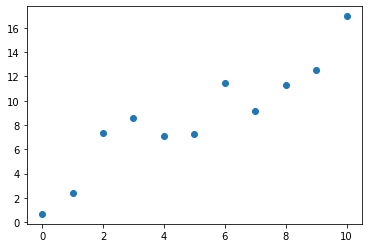

In [7]:
plt.plot(x, y, 'o')

2.2722722722722715
1.2712712712712708


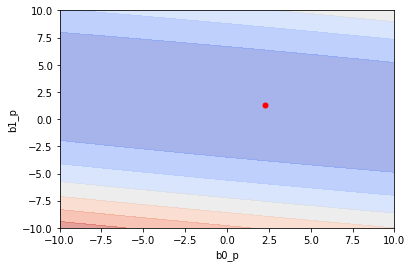

In [8]:
granularity = 1000
b0_p = np.linspace(-10, 10, granularity)
b1_p = np.linspace(-10, 10, granularity)
B0_P, B1_P = np.meshgrid(b0_p, b1_p)
B = np.vstack((B1_P.flatten(), B0_P.flatten()))
X = np.vstack((x, np.ones((1, x.shape[0])))).T
Y_p = np.dot(X, B)
Y = np.repeat(y, granularity * granularity).reshape(y.shape[0], granularity * granularity)
L = np.sum(np.power(Y - Y_p, 2), axis = 0).reshape(granularity, granularity)

fig, ax = plt.subplots()

ax.contourf(B0_P, B1_P, L, cmap=cm.coolwarm, alpha = 0.5, zorder = 0)

ax.set_xlabel('b0_p')
ax.set_ylabel('b1_p')

minimum = np.unravel_index(np.argmin(L), L.shape)
print(B0_P[minimum])
print(B1_P[minimum])
ax.plot(B0_P[minimum], B1_P[minimum], markerfacecolor='red', markeredgecolor='red', marker='o', markersize=5, zorder = 10)